In [285]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

## Data Understanding

### Load Dataset

In [13]:
# Import the data
# goal: predict scalar_coupling_const by its structure
# We will use train set and structures
train_df = pd.read_csv('Data/train.csv')
structures_df = pd.read_csv('Data/structures.csv')

In [14]:
# Observe traindf
print(train_df.shape)
print('')
print(train_df.nunique())
print('')
print(train_df.columns)
train_df.head()

(4659076, 6)

id                          4659076
molecule_name                 85012
atom_index_0                     28
atom_index_1                     29
type                              8
scalar_coupling_constant    2183446
dtype: int64

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [15]:
# Observe structures_df
print(structures_df.shape)
print('')
print(structures_df.nunique())
print('')
print(structures_df.columns)
structures_df.head()

(2358875, 6)

molecule_name     130789
atom_index            29
atom                   5
x                2358802
y                2358808
z                2358792
dtype: int64

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z'], dtype='object')


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


### Exploratory Data Analysis (EDA)

#### Scalar Coupling Constant (Target)

Text(0, 0.5, 'Counts')

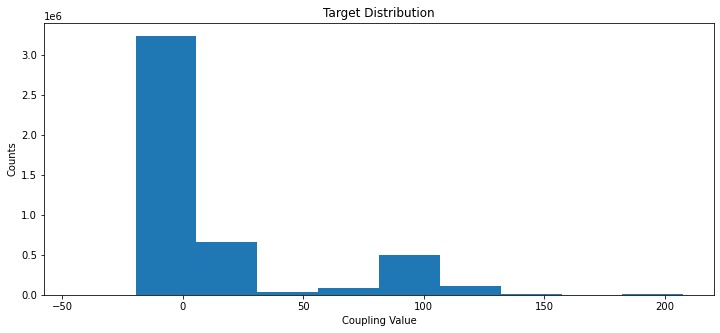

In [21]:
# Check the Distribution of Target Variable
fig, ax = plt.subplots(figsize=(12,5))

ax.hist(train_df['scalar_coupling_constant'])
ax.set_title('Target Distribution')
ax.set_xlabel('Coupling Value')
ax.set_ylabel('Counts')

#### Types of Bond

Text(0, 0.5, 'Counts')

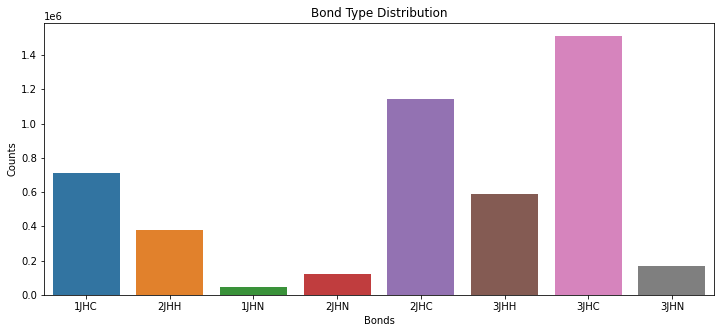

In [24]:
# Check the type of bonds
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='type', data=train_df)
ax.set_title('Bond Type Distribution')
ax.set_xlabel('Bonds')
ax.set_ylabel('Counts')

Multiple bond type might cause the trouble later on the modeling. Therefore we will create a subset based on each model type in later part.

#### Atom Index

Text(0, 0.5, 'Counts')

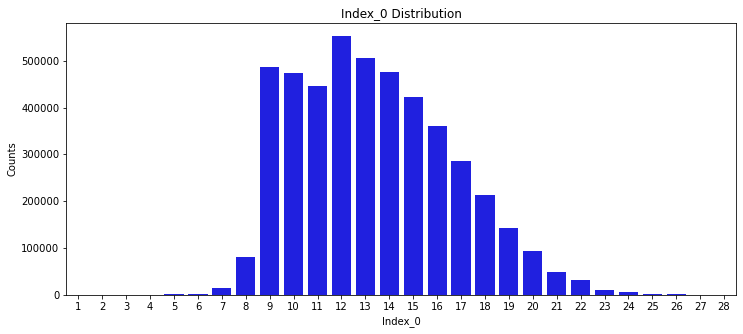

In [37]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_0', data=train_df, color = 'blue')
ax.set_title('Index_0 Distribution')
ax.set_xlabel('Index_0')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

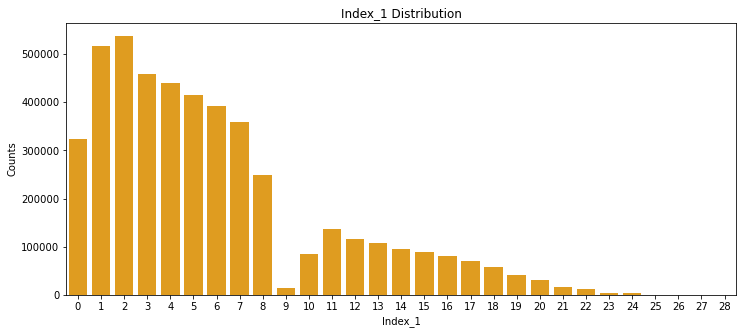

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_1', data=train_df, color = 'orange')
ax.set_title('Index_1 Distribution')
ax.set_xlabel('Index_1')
ax.set_ylabel('Counts')

### Feature Engineering

#### Merge Train and Structure

This merging technique has been sourced from: https://www.kaggle.com/inversion/atomic-distance-benchmark

In [52]:
def map_atom_info(df, atom_idx):
    '''
    
    '''
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [53]:
# Merge train and structures
train_df2 = map_atom_info(train_df, 0)
train_df2 = map_atom_info(train_df2, 1)
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [54]:
# check nan after merging
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dtype: int64

#### Distance between Atoms

In [55]:
# Calculate the 3D distance between atom
train_df2['dx'] = train_df2['x_0']-train_df2['x_1']
train_df2['dy'] = train_df2['y_0']-train_df2['y_1']
train_df2['dz'] = train_df2['z_0']-train_df2['z_1']

train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dx,dy,dz
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,0.014849,-1.091835,-0.006025
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,-1.009580,-1.469782,0.001700
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,0.542965,-1.453558,0.878620
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,0.525964,-1.443964,-0.904421
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.024429,0.377947,-0.007724


Before we enter train test split, we will make a subset of train_df2 based on the bond type.

According to the bar plot in 'Type of Bond' section, we know that there are 8 types of bond:

- {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}

In [190]:
train_df2['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

In [203]:
def subset(btype):
    '''
    This function creates and returns subset of the train_df2. 
    It will locate the rows with certain bond type and generate subset.
    
    input: btype
    Options for btype: {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}
    
    output: subset in form of dataframe
    '''
    df = train_df2.loc[train_df2['type'] == btype]
    
    return df

In [210]:
c1_df = subset('1JHC')
n1_df = subset('1JHN')
c2_df = subset('2JHC')
h2_df = subset('2JHH')
n2_df = subset('2JHN')
c3_df = subset('3JHC')
h3_df = subset('3JHH')
n3_df = subset('3JHN')

In [211]:
# check if the subset are well splitted
print('c1')
print(c1_df['type'].value_counts())
print('')
print('c2')
print(c2_df['type'].value_counts())
print('')
print('c3')
print(c3_df['type'].value_counts())
print('')
print('n1')
print(n1_df['type'].value_counts())
print('')
print('n2')
print(n2_df['type'].value_counts())
print('')
print('n3')
print(n3_df['type'].value_counts())
print('')
print('h2')
print(h2_df['type'].value_counts())
print('')
print('h3')
print(h3_df['type'].value_counts())

c1
1JHC    709133
Name: type, dtype: int64

c2
2JHC    1140867
Name: type, dtype: int64

c3
3JHC    1511207
Name: type, dtype: int64

n1
1JHN    43680
Name: type, dtype: int64

n2
2JHN    119059
Name: type, dtype: int64

n3
3JHN    166613
Name: type, dtype: int64

h2
2JHH    377988
Name: type, dtype: int64

h3
3JHH    590529
Name: type, dtype: int64


#### Train Test Split

We will split the train_df2 into X and y. We will exclude columns id and molecule_name 
- X: All columns else than trarget variable(scalar_coupling_constant), id, molecule_name, and type
    - We will exclude columns id and molecule_name since those two does not contribute to the scalar coupling constant.
    - type will be dropped since all the df are now the subset with same bond type
- y: target variable (scalar_coupling_constant)

We will also create function for whole process since we have to run for each subset.

Moreover, we will conduct train test split twice to create train set, validation set, and test set.The ratio for this split will be 80% for train, 10% for validation and test, which is a common ratio.

In [214]:
def ttv_split(df):
    '''
    This function splits the set of dataframe into train, validation, and test set with ration of 80:10:10.
    '''
    X = df.drop(columns = ['id', 'molecule_name', 'scalar_coupling_constant','type'])
    y = df[['scalar_coupling_constant']]
    
    # Split into train and test
    # ratio train 90% : test 10%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state = 1)
    
    # Split into train and val
    # ratio train 80% : val 10% : test 10%
    # to achieve this test_size should be 1/9
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state =1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [215]:
c1_X_train, c1_X_test, c1_X_val, c1_y_train, c1_y_test, c1_y_val = ttv_split(c1_df)
c2_X_train, c2_X_test, c2_X_val, c2_y_train, c2_y_test, c2_y_val = ttv_split(c2_df)
c3_X_train, c3_X_test, c3_X_val, c3_y_train, c3_y_test, c3_y_val = ttv_split(c3_df)
n1_X_train, n1_X_test, n1_X_val, n1_y_train, n1_y_test, n1_y_val = ttv_split(n1_df)
n2_X_train, n2_X_test, n2_X_val, n2_y_train, n2_y_test, n2_y_val = ttv_split(n2_df)
n3_X_train, n3_X_test, n3_X_val, n3_y_train, n3_y_test, n3_y_val = ttv_split(n3_df)
h2_X_train, h2_X_test, h2_X_val, h2_y_train, h2_y_test, h2_y_val = ttv_split(h2_df)
h3_X_train, h3_X_test, h3_X_val, h3_y_train, h3_y_test, h3_y_val = ttv_split(h3_df)

Great! Train test split was successful.

#### Preprocessing Pipeline

First, we will divide up the columns into numerical and categorical.

In [221]:
# Create a train_df3
# exclude scalar_coupling_constant, id, molecule_name, and type
train_df3 = train_df2.drop(columns=['scalar_coupling_constant', 'id', 'molecule_name', 'type'])

In [222]:
# initialize lists of columns
num_cols = []
cat_cols = []

# num = any columns with numerical value
# cat = everything else
for c in train_df3.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [223]:
num_cols

['atom_index_0',
 'atom_index_1',
 'x_0',
 'y_0',
 'z_0',
 'x_1',
 'y_1',
 'z_1',
 'dx',
 'dy',
 'dz']

In [224]:
cat_cols

['atom_0', 'atom_1']

First, define the transformers for each column type using pipeline.

In [280]:
class MyLabelEncoder(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelEncoder(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [286]:
# Define transformers using pipeline
num_transformer = Pipeline(steps=[('minmaxscaler', MinMaxScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

Then, combine transformers into preprocessor using ColumnTransformer.

In [287]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])

Finally, we will fit the preprocessor to X_train

In [288]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['atom_index_0', 'atom_index_1', 'x_0', 'y_0',
                                  'z_0', 'x_1', 'y_1', 'z_1', 'dx', 'dy',
                                  'dz']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['atom_0', 'atom_1'])])

## Modeling

### 1. First Simple Model

Our first simple model will be the linear regression model.

In [257]:
def fit_and_eval(regressor, X_train, y_train, X_val, y_val):
    model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', regressor)
                        ])
    #print(cross_validate(lr, X_train, y_train, return_train_score=True))
    lr.fit(X_train, y_train)
    tr_pred = lr.predict(X_train)
    val_pred = lr.predict(X_val)
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Validation MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    plt.scatter(y_val,val_pred)
    plt.plot(y_val, y_val, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')

#### 1.1 1JHC

Result Report

Train R2 Score: 0.18084707234187392
Validation R2 Score: 0.17918145223064363

Train RMSE: 16.528667017899725
Validation RMSE: 16.708504391519625

Validation MAE: 11.034283400799957
Validation MAE: 11.109466360921108


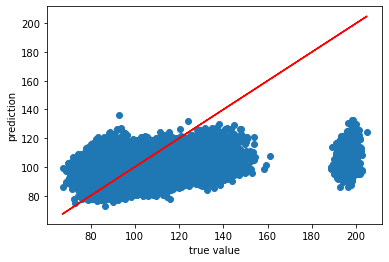

In [258]:
fit_and_eval(LinearRegression(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 1.2 1JHN

Result Report

Train R2 Score: 0.04110228251875703
Validation R2 Score: 0.0491194584517608

Train RMSE: 10.663782017542303
Validation RMSE: 10.718242186246428

Validation MAE: 9.440619208982138
Validation MAE: 9.499376073592748


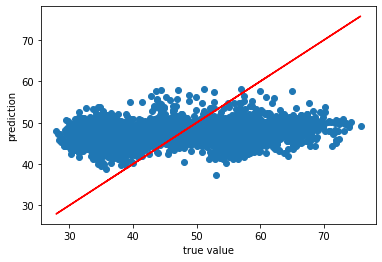

In [259]:
fit_and_eval(LinearRegression(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 1.3 2JHC

Result Report

Train R2 Score: 0.02776270216889143
Validation R2 Score: 0.028268389206864586

Train RMSE: 4.46174232964397
Validation RMSE: 4.469129447271786

Validation MAE: 2.6663823230364687
Validation MAE: 2.662733866368087


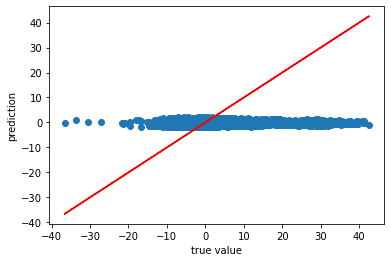

In [260]:
fit_and_eval(LinearRegression(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 1.4 2JHH

Result Report

Train R2 Score: 0.049898605369534166
Validation R2 Score: 0.053123309053698

Train RMSE: 3.874152989165542
Validation RMSE: 3.9228693522800024

Validation MAE: 2.6122290504162673
Validation MAE: 2.642424213009934


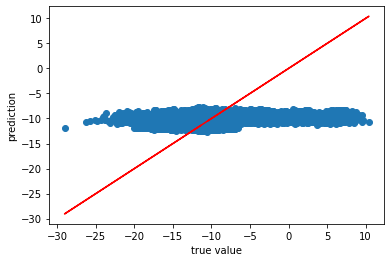

In [261]:
fit_and_eval(LinearRegression(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 1.5 2JHN

Result Report

Train R2 Score: 0.10526120897788782
Validation R2 Score: 0.1188457405217005

Train RMSE: 3.4797777701490613
Validation RMSE: 3.443029672234286

Validation MAE: 2.708336396104339
Validation MAE: 2.678877964660675


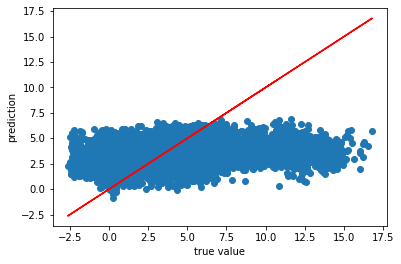

In [262]:
fit_and_eval(LinearRegression(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 1.6 3JHC

Result Report

Train R2 Score: 0.0028499008188801467
Validation R2 Score: 0.0027361229401129394

Train RMSE: 3.07063229362273
Validation RMSE: 3.0737561154691178

Validation MAE: 2.488028225087651
Validation MAE: 2.4894507060381255


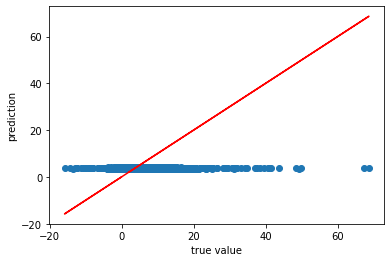

In [263]:
fit_and_eval(LinearRegression(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 1.7 3JHH

Result Report

Train R2 Score: 0.011352107048089866
Validation R2 Score: 0.010679261908656645

Train RMSE: 3.6853355045932092
Validation RMSE: 3.678806778984004

Validation MAE: 3.082547459160539
Validation MAE: 3.0746439459976633


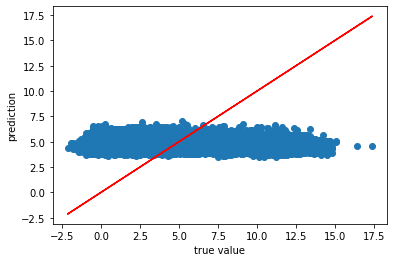

In [264]:
fit_and_eval(LinearRegression(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 1.8 3JHN

Result Report

Train R2 Score: 0.007117464221254699
Validation R2 Score: 0.006401565963651823

Train RMSE: 1.3147232515897744
Validation RMSE: 1.323379669126464

Validation MAE: 0.9667091406588784
Validation MAE: 0.9691831290136239


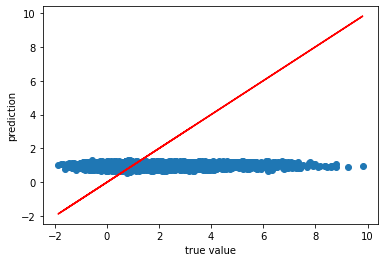

In [265]:
fit_and_eval(LinearRegression(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

Our linear regression models results proves that the none of the bond type can be explained with simple linear regression. All of them shows the very small r squared value.

### 2. Random Forest Regressor

#### 2.1 1JHC

Result Report

Train R2 Score: 0.18084707234187392
Validation R2 Score: 0.17918145223064363

Train RMSE: 16.528667017899725
Validation RMSE: 16.708504391519625

Validation MAE: 11.034283400799957
Validation MAE: 11.109466360921108


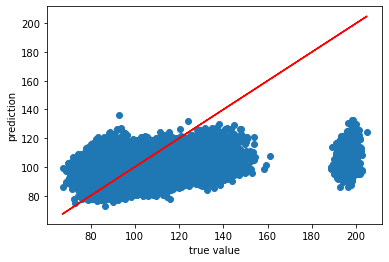

In [266]:
fit_and_eval(RandomForestRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

### 3. Neural Networks

In [169]:
X_train.shape

(3727260, 14)

In [ ]:
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer,input_shape = (14,)))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='linear',kernel_initializer=kernel_initializer))

    model.compile(loss='mean_absolute_error',optimizer=optimizer)

    return model

<3727260x16880704 sparse matrix of type '<class 'numpy.float64'>'
	with 52181640 stored elements in Compressed Sparse Row format>

ValueError: could not convert string to float: '2JHC'

In [176]:
nn1.fit(X_train, y_train, validation_data=(X_val,y_val.values),epochs=10, batch_size=10)

ValueError: Pipeline.fit does not accept the validation_data parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.